## Embeddings extraction
On this notebook I will compare a target image to a pool of other images, this simulates the process where a customer uploads his picture that will be compared to a store catalogue images.  

The strategy will be to use a neural network already trained on the imagenet dataset and use it to extract the embeddings of all the store images. These embeddings will be saved and when a new image is uploaded to the server the embedding of that image will be extracted and compared to the other ones where the "n" most similar images will be returned. To compare the images cosine similarity will be used.

For efficiency purposes embeddings are run only once and exported to a csv file, then the file is loaded into memory.

## To do
- Set up sampling strategy so results can be replicated and compared
- Improve accuracy model, ideas:
    - Explore different pretrained NNs
    - Tuning KNN algorithm
    - Explore optimal resizing values
    - Reduce noise in image pairs (bad images)
    - Fix cropping customer images
    - Retrain a NN with triplet loss
    - ...
- TSNE
- Fix issues below
    - Duplicate images:
    Some photos may appear in both customer and retrieval folders with different photo id. List below:  
    10104, 10222 - customer belt  
    77679, 77678 - retrieval belt
    - Blank images  
    To be removed (see last on ranked images) 336452
    - Some bboxes are wrong from source  
    See img 8288 which is a bag and has 0 height and width
    - Sample = None on shell bug

In [1]:
import os
import sys
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as patches
import matplotlib.image as mpimg
from tqdm import tqdm_notebook as tqdm
from keras.applications.inception_v3 import InceptionV3 , preprocess_input
from keras.preprocessing import image
from PIL import Image
import cv2
from scipy.spatial.distance import cdist
from extract_train_val_test import extract_train_val_test
%matplotlib inline
pd.options.mode.chained_assignment = None  #disables .loc assignment warning
# pip install h5py==2.8.0rc1 to disable the h5py warning

Using TensorFlow backend.


### Loading  images

In [52]:
def show_image(img_path, title="Image", bbox=False):
    fig,ax = plt.subplots(1, figsize=(5,5))
    img_array = mpimg.imread(img_path)
    if len(img_array.shape) == 2: #fixes exception with B&W images having only 2 colour channels ie. 4540.jpg
            img_array = np.array(Image.fromarray(img_array).convert("RGB"))

    ax.imshow(img_array)
    plt.title(title)
    plt.axis("off")
    
    if bbox == True:
        img_id = re.split("(\\d+)", img_path)[-2]
        img_data = customer_df[customer_df["photo"] == int(img_id)]
        
        if img_data["category"].unique().shape[0] > 1: #exception, image with multiple categories
            print("Categories: ", img_data["category"].value_counts().index.tolist())
            img_category = input("Please specify category: ")
            img_data = img_data[img_data["category"] == img_category]
            
        for index, row in img_data.iterrows(): #exception, image with multiple bboxes, plots all
            top = int(row["top"])
            left = int(row["left"])
            width = int(row["width"])
            height = int(row["height"]) #xy = (left, top)
            rect = patches.Rectangle(xy=(left,top),width=width,height=height,linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)
                        
        plt.show()
                        
def crop_image(img_path, resize=(250,250), show=False):
    img_array = mpimg.imread(img_path)
    img_id = re.split("(\\d+)", img_path)[-2]
    img_df = customer_df[customer_df["photo"] == int(img_id)]
    if len(img_df) > 1: #to simplify, only using 1 bbox
        img_df["fix_bbox"] = img_df.loc[:,"height"] + img_df.loc[:,"width"] #aggs height and width, sorts them and picks the largest box
        img_df = img_df.sort_values(by="fix_bbox", ascending=False)[0:1] #this fixes a bug with some bboxes being 1px long
        img_df = img_df[0:1]
    x0 = int(img_df["left"])
    y0 = int(img_df["top"])
    width = int(img_df["width"])
    height = int(img_df["height"])
    
    if len(img_array.shape) == 2: #fixes exception with B&W images having only 2 colour channels ie. 4540.jpg
        img_array = np.array(Image.fromarray(img_array).convert("RGB"))

    image_cropped = img_array[y0:y0+height , x0:x0+width, :]    
    image_cropped = cv2.resize(image_cropped, dsize=resize, interpolation=cv2.INTER_CUBIC)

    if show == True:
        plt.imshow(image_cropped)
        plt.title("Cropped image")
        plt.axis("off")
        return plt.show()
    
    return image_cropped

def show_recommend(ids, dataset_path, img_path, resize =(250,250), bbox=True):
    show_image(img_path, title = "User image", bbox=True)
    crop_image(img_path, show=True, resize=resize)
    
    img_paths = find_paths(dataset_path)
    print("Top {} similar images".format(len(ids)))
    fig = plt.figure(figsize=(20,20))
    gs = gridspec.GridSpec(1, len(ids))
    for i in range(len(ids)):
        ax = fig.add_subplot(gs[0, i])
        ax.imshow(mpimg.imread(img_paths[ids[i]]))
        ax.axis("off")
    plt.show()

## Preprocessing images

In [46]:
# Returns the array representation of all images in the path specified in raw format for display and processed format for the NN
def find_paths(dataset_path):
    img_paths = os.listdir(dataset_path)
    img_paths = sorted(img_paths, key = lambda x: int(re.sub("(\\D)", "", x))) #sorts numeric rather than str
    img_paths = [os.path.join(dataset_path, img) for img in img_paths]
    return img_paths

def save_embeddings(dataset_path, resize=(250,250)):
    imgs = find_paths(dataset_path)
    embeddings_tensor = np.zeros((len(imgs), 2048)) #test with np.empty
    
    with tqdm(total=len(imgs)) as pbar:
        for n, img in enumerate(imgs):
            img_array = plt.imread(img)
            img_array = cv2.resize(img_array, dsize=resize, interpolation=cv2.INTER_CUBIC)
            img_array = preprocess_input(img_array)
            img_array = model.predict(np.expand_dims(img_array, axis=0)) #ouput shape (6,6,2048)
            embeddings_tensor[n] = img_array.flatten()
            pbar.update(1)
    embeddings_tensor = embeddings_tensor.astype(np.float16)
    
    print("Writing to file")
    np.save("embeddings_" + category + ".npy", embeddings_tensor) #npy files save/load faster than csv when working with ndarrays
    
def recommend_user(img_path, embs_catalogue, retrieval_df, resize=(250,250), bbox=True, method="cosine"):
    if bbox == True:
        img_array = crop_image(img_path) #crops to bbox and resizes
    else:
        img_array = plt.imread(img_path) #allows testing with an image without bboxes
        img_array = cv2.resize(img_array, dsize=resize, interpolation=cv2.INTER_CUBIC)
        if len(img_array.shape) == 2: #fixes exception with B&W images having only 2 colour channels ie. 4540.jpg
            img_array = np.array(Image.fromarray(img_array).convert("RGB")) #already includded in crop_image

    if img_array.shape[2] > 3: #fixes exception with CMYK images having 4 colour channels ie. 4622.jpg
        img_array = np.array(Image.fromarray(img_array).convert("RGB"))

    proc_img = preprocess_input(np.expand_dims(img_array, axis=0)) #preprocess to NN format
    embs_target = model.predict(proc_img)#.flatten() #extracts embedding
    
    distance = cdist(embs_catalogue, embs_target.reshape(1,-1), method) #run distances from user photo to catalogue
    rank = np.argsort(distance.ravel()) #ranks by similarity, returns the indices that would sort the distance array
    return rank

def rank_similar(target_img, customer_val_df, retrieval_val_df, rank):
    img_name = re.split("(\\d+)", target_img)[-2]
    target_df = customer_val_df[customer_val_df["photo"] == int(img_name)] #finds image name
    target_id = target_df["id"].unique().tolist()[0] #finds its image id
    
    retrieval_ranked = retrieval_val_df.iloc[rank] #reindex based on knn distances
    retrieval_ranked = retrieval_ranked.drop_duplicates(subset=["id"], keep="first") #ensures only the best match for each item is taken into account
    retrieval_ranked = retrieval_ranked.reset_index(drop=True) #resets index
    same_images_rank = retrieval_ranked[retrieval_ranked["id"] == target_id].index.values.tolist() #extracts index positions
    return same_images_rank

In [67]:
customer_df = pd.read_csv("./customer_df.csv")
retrieval_df = pd.read_csv("./retrieval_df.csv")
category = "dresses"
dataset_path = "./photos_classified/" + category + "/validation/"
resizing = (250,250)

retrieval_df = retrieval_df[retrieval_df["category"] == category]
customer_df = customer_df[customer_df["category"] == category]
customer_df[["height", "left", "top", "width"]] = customer_df[["height", "left", "top", "width"]].astype(int)

In [68]:
%time
extract_train_val_test(category, [0.5, 0.5], sampling=2000, sampling_unmatched=1000)

Wall time: 0 ns
Creating customer validation images


100%|█████████████████████████████████████████████████████████████████████████████| 1670/1670 [00:04<00:00, 352.22it/s]


Creating retrieval validation images


100%|█████████████████████████████████████████████████████████████████████████████| 2778/2778 [00:04<00:00, 675.42it/s]


Creating customer test images


100%|█████████████████████████████████████████████████████████████████████████████| 1693/1693 [00:05<00:00, 320.42it/s]


Creating retrieval test images


100%|█████████████████████████████████████████████████████████████████████████████| 2757/2757 [00:04<00:00, 679.21it/s]


In [69]:
#filters the customer dataframe with the images from the validation folder only
mask_custom = pd.Series(
    [str(photo)+'.jpg' for photo in customer_df['photo']]).isin(os.listdir(dataset_path+"customer"))
mask_retriev = pd.Series(
    [str(photo)+'.jpg' for photo in retrieval_df['photo']]).isin(os.listdir(dataset_path+"retrieval"))

customer_val_df = customer_df.reset_index(drop=True)[mask_custom].sort_values(by='photo', ascending=True)
retrieval_val_df = retrieval_df.reset_index(drop=True)[mask_retriev].sort_values(by='photo', ascending=True)

In [7]:
# include_top=False removes the fully connected layer at the end/top of the network. This allows us to get the feature vector as opposed to a classification.
# pooling: Optional pooling mode for feature extraction when include_top is False.
#     None means that the output of the model will be the 4D tensor output of the last convolutional layer.
#     'avg' means that global average pooling will be applied to the output of the last convolutional layer, and thus the output of the model will be a 2D tensor.
#     'max' means that global max pooling will be applied.

model = InceptionV3(weights="imagenet", include_top=False, pooling="avg")

In [70]:
%%time
#ONLY RUN THE FIRST TIME TO SAVE ALL EMBEDDINGS TO DISK
save_embeddings(dataset_path+"retrieval", resize=resizing) #Needed to calculate embeddings from catalogue


Writing to file
Wall time: 1min 40s


In [71]:
embs_catalogue = np.load("./embeddings_" + category + ".npy")

## Visual evaluation

In [72]:
customer_val_df.sample(10)["photo"] #sample picks for visual evaluation

12363    13839
4329     12521
8625     14251
5209        26
1822     15053
5896     15524
5739      7790
2703       440
3253     13517
655      14793
Name: photo, dtype: int64

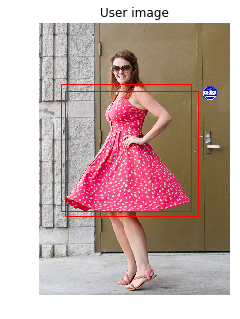

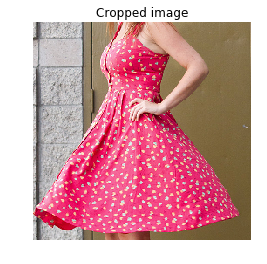

Top 10 similar images


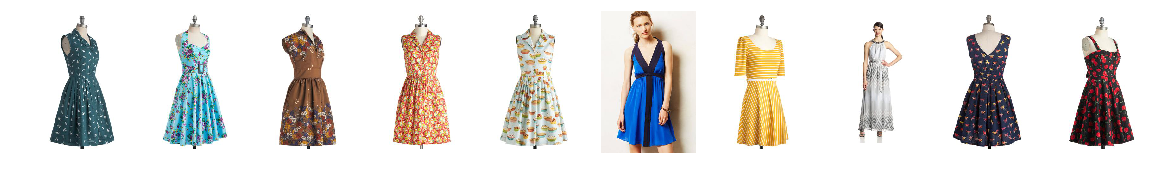

Same images ranked on indices: [185]
Wall time: 943 ms


In [74]:
%%time
target_img = "./photos_classified/" + category + "/validation/customer/12521.jpg"
rank = recommend_user(target_img, embs_catalogue, retrieval_val_df, resize=resizing)

n = 10
show_recommend(rank[0:n], dataset_path+"retrieval", target_img, resize=resizing)
similar_ranked = rank_similar(target_img, customer_val_df, retrieval_val_df, rank)
print("Same images ranked on indices: {}".format(similar_ranked))

## Measuring model performance

Once we have created a embeddings catalogue from which the most "n" similiar images are returned we need to measure how this process is performing.<br>
This score will allow us to make improvements and meassure them, in order to find the best parameters and methods.

For the evaluation we will only use the customer photos, and each one of them will be compared with the retrieved photos. As a result we will obtain a rank starting from the most similar photo. Then we will define a K parámeter that will set the top k images from the returned rank.

For the evaluation we will use the following method:
   - Accuracy@K: total number of positive cases / total number of cases

In [75]:
customer_unique_photos = customer_val_df.drop_duplicates(subset=["photo"]) #discards duplicate bboxes for calculation
matches_df = customer_unique_photos.merge(retrieval_val_df, how="inner", on="id", suffixes=("_cust", "_retr"))
print("Total matches 1:all : ", matches_df.shape[0]) #need to look into this to get more

Total matches 1:all :  3251


In [76]:
def evaluate(customer_df, retrieval_df, validation_path, embs_catalogue, k_list, resize=(250,250), method="cosine"):
    customer_paths = find_paths(validation_path + "customer")
    
    print("Total customer images: {}".format(len(customer_paths)))
    with tqdm(total=len(customer_paths)) as pbar:
        all_positives = np.empty((1, len(k_list)))[0]   #all positive cases to calculate accuracy
        for n, customer_path in enumerate(customer_paths):
            print(customer_path)
            rank = recommend_user(customer_path, embs_catalogue, retrieval_df, resize=resize, method=method)
            retrieval_ranked = retrieval_df.iloc[rank] #retrieval ranked
            retrieval_ranked = retrieval_ranked.drop_duplicates(subset=["id"], keep="first") #ensures only the best match for each item is taken into account

            for i, k in enumerate(k_list):
                retrieval_ranked_list = retrieval_ranked[:k]["id"].tolist()

                photo_name = re.split("(\\d+)", customer_path)[-2]
                image_customer = customer_df[customer_df["photo"] == int(photo_name)]
                image_id = image_customer['id'].tolist()[0] #always same id even if more than >1 rows

                if image_id in retrieval_ranked_list:
                    all_positives[i] += 1
            pbar.update(1)
        
        for i, k in enumerate(k_list):
            accuracy = all_positives[i] / len(customer_paths)            
            print("Accuracy at {}: {:.3f}%".format(k, accuracy*100))

In [77]:
%%time
k = [5,10,20,50]
evaluate(customer_val_df, retrieval_val_df, dataset_path, embs_catalogue, k, resize=resizing)

Total customer images: 1670


./photos_classified/dresses/validation/customer\1.jpg
./photos_classified/dresses/validation/customer\26.jpg
./photos_classified/dresses/validation/customer\29.jpg
./photos_classified/dresses/validation/customer\39.jpg
./photos_classified/dresses/validation/customer\62.jpg
./photos_classified/dresses/validation/customer\78.jpg
./photos_classified/dresses/validation/customer\89.jpg
./photos_classified/dresses/validation/customer\98.jpg
./photos_classified/dresses/validation/customer\114.jpg
./photos_classified/dresses/validation/customer\116.jpg
./photos_classified/dresses/validation/customer\132.jpg
./photos_classified/dresses/validation/customer\138.jpg
./photos_classified/dresses/validation/customer\141.jpg
./photos_classified/dresses/validation/customer\160.jpg
./photos_classified/dresses/validation/customer\177.jpg
./photos_classified/dresses/validation/customer\183.jpg
./photos_classified/dresses/validation/customer\204.jpg
./photos_classified/dresses/validation/customer\206.jpg
.

./photos_classified/dresses/validation/customer\1654.jpg
./photos_classified/dresses/validation/customer\1675.jpg
./photos_classified/dresses/validation/customer\1683.jpg
./photos_classified/dresses/validation/customer\1719.jpg
./photos_classified/dresses/validation/customer\1721.jpg
./photos_classified/dresses/validation/customer\1758.jpg
./photos_classified/dresses/validation/customer\1766.jpg
./photos_classified/dresses/validation/customer\1768.jpg
./photos_classified/dresses/validation/customer\1769.jpg
./photos_classified/dresses/validation/customer\1773.jpg
./photos_classified/dresses/validation/customer\1774.jpg
./photos_classified/dresses/validation/customer\1790.jpg
./photos_classified/dresses/validation/customer\1800.jpg
./photos_classified/dresses/validation/customer\1804.jpg
./photos_classified/dresses/validation/customer\1812.jpg
./photos_classified/dresses/validation/customer\1813.jpg
./photos_classified/dresses/validation/customer\1817.jpg
./photos_classified/dresses/val

./photos_classified/dresses/validation/customer\3524.jpg
./photos_classified/dresses/validation/customer\3525.jpg
./photos_classified/dresses/validation/customer\3526.jpg
./photos_classified/dresses/validation/customer\3533.jpg
./photos_classified/dresses/validation/customer\3538.jpg
./photos_classified/dresses/validation/customer\3553.jpg
./photos_classified/dresses/validation/customer\3565.jpg
./photos_classified/dresses/validation/customer\3567.jpg
./photos_classified/dresses/validation/customer\3571.jpg
./photos_classified/dresses/validation/customer\3584.jpg
./photos_classified/dresses/validation/customer\3591.jpg
./photos_classified/dresses/validation/customer\3592.jpg
./photos_classified/dresses/validation/customer\3610.jpg
./photos_classified/dresses/validation/customer\3629.jpg
./photos_classified/dresses/validation/customer\3634.jpg
./photos_classified/dresses/validation/customer\3638.jpg
./photos_classified/dresses/validation/customer\3655.jpg
./photos_classified/dresses/val

./photos_classified/dresses/validation/customer\5242.jpg
./photos_classified/dresses/validation/customer\5253.jpg
./photos_classified/dresses/validation/customer\5264.jpg
./photos_classified/dresses/validation/customer\5274.jpg
./photos_classified/dresses/validation/customer\5281.jpg
./photos_classified/dresses/validation/customer\5316.jpg
./photos_classified/dresses/validation/customer\5324.jpg
./photos_classified/dresses/validation/customer\5344.jpg
./photos_classified/dresses/validation/customer\5360.jpg
./photos_classified/dresses/validation/customer\5363.jpg
./photos_classified/dresses/validation/customer\5405.jpg
./photos_classified/dresses/validation/customer\5407.jpg
./photos_classified/dresses/validation/customer\5417.jpg
./photos_classified/dresses/validation/customer\5470.jpg
./photos_classified/dresses/validation/customer\5489.jpg
./photos_classified/dresses/validation/customer\5497.jpg
./photos_classified/dresses/validation/customer\5506.jpg
./photos_classified/dresses/val

./photos_classified/dresses/validation/customer\6967.jpg
./photos_classified/dresses/validation/customer\6983.jpg
./photos_classified/dresses/validation/customer\7026.jpg
./photos_classified/dresses/validation/customer\7028.jpg
./photos_classified/dresses/validation/customer\7037.jpg
./photos_classified/dresses/validation/customer\7048.jpg
./photos_classified/dresses/validation/customer\7053.jpg
./photos_classified/dresses/validation/customer\7082.jpg
./photos_classified/dresses/validation/customer\7089.jpg
./photos_classified/dresses/validation/customer\7091.jpg
./photos_classified/dresses/validation/customer\7143.jpg
./photos_classified/dresses/validation/customer\7154.jpg
./photos_classified/dresses/validation/customer\7180.jpg
./photos_classified/dresses/validation/customer\7189.jpg
./photos_classified/dresses/validation/customer\7194.jpg
./photos_classified/dresses/validation/customer\7203.jpg
./photos_classified/dresses/validation/customer\7221.jpg
./photos_classified/dresses/val

./photos_classified/dresses/validation/customer\8802.jpg
./photos_classified/dresses/validation/customer\8820.jpg
./photos_classified/dresses/validation/customer\8825.jpg
./photos_classified/dresses/validation/customer\8841.jpg
./photos_classified/dresses/validation/customer\8848.jpg
./photos_classified/dresses/validation/customer\8879.jpg
./photos_classified/dresses/validation/customer\8880.jpg
./photos_classified/dresses/validation/customer\8884.jpg
./photos_classified/dresses/validation/customer\8901.jpg
./photos_classified/dresses/validation/customer\8918.jpg
./photos_classified/dresses/validation/customer\8932.jpg
./photos_classified/dresses/validation/customer\8946.jpg
./photos_classified/dresses/validation/customer\8952.jpg
./photos_classified/dresses/validation/customer\8960.jpg
./photos_classified/dresses/validation/customer\8966.jpg
./photos_classified/dresses/validation/customer\8974.jpg
./photos_classified/dresses/validation/customer\8981.jpg
./photos_classified/dresses/val

./photos_classified/dresses/validation/customer\10379.jpg
./photos_classified/dresses/validation/customer\10385.jpg
./photos_classified/dresses/validation/customer\10392.jpg
./photos_classified/dresses/validation/customer\10393.jpg
./photos_classified/dresses/validation/customer\10400.jpg
./photos_classified/dresses/validation/customer\10401.jpg
./photos_classified/dresses/validation/customer\10409.jpg
./photos_classified/dresses/validation/customer\10424.jpg
./photos_classified/dresses/validation/customer\10435.jpg
./photos_classified/dresses/validation/customer\10457.jpg
./photos_classified/dresses/validation/customer\10465.jpg
./photos_classified/dresses/validation/customer\10483.jpg
./photos_classified/dresses/validation/customer\10489.jpg
./photos_classified/dresses/validation/customer\10492.jpg
./photos_classified/dresses/validation/customer\10530.jpg
./photos_classified/dresses/validation/customer\10547.jpg
./photos_classified/dresses/validation/customer\10548.jpg
./photos_class

./photos_classified/dresses/validation/customer\12277.jpg
./photos_classified/dresses/validation/customer\12279.jpg
./photos_classified/dresses/validation/customer\12286.jpg
./photos_classified/dresses/validation/customer\12289.jpg
./photos_classified/dresses/validation/customer\12291.jpg
./photos_classified/dresses/validation/customer\12293.jpg
./photos_classified/dresses/validation/customer\12305.jpg
./photos_classified/dresses/validation/customer\12310.jpg
./photos_classified/dresses/validation/customer\12311.jpg
./photos_classified/dresses/validation/customer\12320.jpg
./photos_classified/dresses/validation/customer\12323.jpg
./photos_classified/dresses/validation/customer\12329.jpg
./photos_classified/dresses/validation/customer\12338.jpg
./photos_classified/dresses/validation/customer\12360.jpg
./photos_classified/dresses/validation/customer\12372.jpg
./photos_classified/dresses/validation/customer\12375.jpg
./photos_classified/dresses/validation/customer\12406.jpg
./photos_class

./photos_classified/dresses/validation/customer\14008.jpg
./photos_classified/dresses/validation/customer\14016.jpg
./photos_classified/dresses/validation/customer\14018.jpg
./photos_classified/dresses/validation/customer\14035.jpg
./photos_classified/dresses/validation/customer\14048.jpg
./photos_classified/dresses/validation/customer\14058.jpg
./photos_classified/dresses/validation/customer\14073.jpg
./photos_classified/dresses/validation/customer\14089.jpg
./photos_classified/dresses/validation/customer\14094.jpg
./photos_classified/dresses/validation/customer\14111.jpg
./photos_classified/dresses/validation/customer\14134.jpg
./photos_classified/dresses/validation/customer\14144.jpg
./photos_classified/dresses/validation/customer\14168.jpg
./photos_classified/dresses/validation/customer\14171.jpg
./photos_classified/dresses/validation/customer\14184.jpg
./photos_classified/dresses/validation/customer\14191.jpg
./photos_classified/dresses/validation/customer\14193.jpg
./photos_class

./photos_classified/dresses/validation/customer\15475.jpg
./photos_classified/dresses/validation/customer\15521.jpg
./photos_classified/dresses/validation/customer\15524.jpg
./photos_classified/dresses/validation/customer\15531.jpg
./photos_classified/dresses/validation/customer\15534.jpg
./photos_classified/dresses/validation/customer\15536.jpg
./photos_classified/dresses/validation/customer\15552.jpg
./photos_classified/dresses/validation/customer\15556.jpg
./photos_classified/dresses/validation/customer\15589.jpg
./photos_classified/dresses/validation/customer\15603.jpg
./photos_classified/dresses/validation/customer\15618.jpg
./photos_classified/dresses/validation/customer\15626.jpg
./photos_classified/dresses/validation/customer\15631.jpg
./photos_classified/dresses/validation/customer\15639.jpg
./photos_classified/dresses/validation/customer\15670.jpg
./photos_classified/dresses/validation/customer\15682.jpg
./photos_classified/dresses/validation/customer\15686.jpg
./photos_class

./photos_classified/dresses/validation/customer\17273.jpg
./photos_classified/dresses/validation/customer\17278.jpg
./photos_classified/dresses/validation/customer\17297.jpg
./photos_classified/dresses/validation/customer\17305.jpg
./photos_classified/dresses/validation/customer\17310.jpg
./photos_classified/dresses/validation/customer\17342.jpg
./photos_classified/dresses/validation/customer\17343.jpg
./photos_classified/dresses/validation/customer\17345.jpg
./photos_classified/dresses/validation/customer\17348.jpg
./photos_classified/dresses/validation/customer\17355.jpg
./photos_classified/dresses/validation/customer\17363.jpg
./photos_classified/dresses/validation/customer\17368.jpg
./photos_classified/dresses/validation/customer\17394.jpg
./photos_classified/dresses/validation/customer\17407.jpg
./photos_classified/dresses/validation/customer\17409.jpg
./photos_classified/dresses/validation/customer\17444.jpg
./photos_classified/dresses/validation/customer\17455.jpg
./photos_class

./photos_classified/dresses/validation/customer\98506.jpg
./photos_classified/dresses/validation/customer\98515.jpg
./photos_classified/dresses/validation/customer\98525.jpg
./photos_classified/dresses/validation/customer\98526.jpg
./photos_classified/dresses/validation/customer\98533.jpg
./photos_classified/dresses/validation/customer\98574.jpg
./photos_classified/dresses/validation/customer\98601.jpg
./photos_classified/dresses/validation/customer\98602.jpg
./photos_classified/dresses/validation/customer\98621.jpg
./photos_classified/dresses/validation/customer\98633.jpg
./photos_classified/dresses/validation/customer\98648.jpg
./photos_classified/dresses/validation/customer\98649.jpg
./photos_classified/dresses/validation/customer\98728.jpg
./photos_classified/dresses/validation/customer\98738.jpg
./photos_classified/dresses/validation/customer\98745.jpg
./photos_classified/dresses/validation/customer\98753.jpg
./photos_classified/dresses/validation/customer\98758.jpg
./photos_class